In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

interactive_plots = True
if not interactive_plots:
    pio.renderers.default = "png"
else:
    pio.renderers.default = "jupyterlab"
    

***
## loading data

In [2]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet("../ump-dataset/train.parquet", columns=features)
display(features)

target = pd.read_parquet("../ump-dataset/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet("../ump-dataset/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [3]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [4]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.3
valid_size = int(valid_prop * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 363


In [5]:
valid_time_ids = time_ids[-valid_size:]

In [6]:
train_idx = time.query("time_id not in @valid_time_ids").index
valid_idx = time.query("time_id in @valid_time_ids").index

# dataframes for metric calculation
oof = target.loc[valid_idx,:].copy()
oof["time_id"] = time.loc[valid_idx,"time_id"]
features_valid = features.loc[valid_idx,:]

# input dataset for lgbm
train_dset = lgb.Dataset(
    data=features.loc[train_idx,:],
    label=target.loc[train_idx,"target"].values,
    free_raw_data=True
)
valid_dset = lgb.Dataset(
    data=features.loc[valid_idx,:],
    label=target.loc[valid_idx,"target"].values,
    free_raw_data=True
)

In [7]:
import gc
gc.collect()

35

***
## Bayesian Optimization

In [8]:
default_params = {
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': int(1e8),
    'feature_pre_filter' : False,
}

In [9]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [10]:
def objective(trial):    
    sampled_params = dict(
        num_leaves = 2 ** trial.suggest_int("num_leaves_exp", 4, 10),
        feature_fraction = trial.suggest_discrete_uniform("feature_fraction", 0.2, 1.0, 0.05),
        bagging_fraction = trial.suggest_discrete_uniform("bagging_fraction", 0.5, 1.0, 0.05),
        lambda_l1 = trial.suggest_loguniform("lambda_l1", 1e-3, 1e1),
        lambda_l2 = trial.suggest_loguniform("lambda_l2", 1e-3, 1e1),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 10, 250, 10),
        path_smooth = trial.suggest_float("path_smooth", 0., 10.),
    )
    model_params = {**default_params, **sampled_params}
    
    es_callback = lgb.early_stopping(stopping_rounds=50, first_metric_only=False, verbose=False)
    
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=5000,
        valid_sets=[valid_dset,],
        feval=pearsonr,
        callbacks=[es_callback,],
    )
    
    # metric calculation
    _oof = oof.copy()
    _oof["pred"] = model.predict(features_valid)
    corrs = _oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    
    return corr_mean            

In [11]:
study = optuna.create_study(
    study_name="lgbm-gbrt",
    direction='maximize',
    storage='sqlite:///lgbm-gbrt.db',
    load_if_exists=True,
)
study.optimize(
    objective, 
    n_trials=2000, 
    timeout=43200, # 12-hrs
    n_jobs=1, 
    gc_after_trial=True,
) 

[I 2022-02-07 23:01:44,781] A new study created in RDB with name: lgbm-gbrt
[I 2022-02-07 23:04:56,280] Trial 0 finished with value: 0.11935716663600411 and parameters: {'num_leaves_exp': 10, 'feature_fraction': 0.25, 'bagging_fraction': 0.7, 'lambda_l1': 0.002942883160714104, 'lambda_l2': 0.11475883366626134, 'min_data_in_leaf': 250, 'path_smooth': 2.46585131416634}. Best is trial 0 with value: 0.11935716663600411.
[I 2022-02-07 23:10:09,308] Trial 1 finished with value: 0.12034765153302016 and parameters: {'num_leaves_exp': 9, 'feature_fraction': 1.0, 'bagging_fraction': 0.75, 'lambda_l1': 0.25109312164988734, 'lambda_l2': 1.2030194958988008, 'min_data_in_leaf': 220, 'path_smooth': 6.820445920292163}. Best is trial 1 with value: 0.12034765153302016.
[I 2022-02-07 23:15:33,481] Trial 2 finished with value: 0.12281534985025781 and parameters: {'num_leaves_exp': 5, 'feature_fraction': 0.55, 'bagging_fraction': 0.95, 'lambda_l1': 0.0027476262314083165, 'lambda_l2': 0.19601507619275976, '

In [12]:
study.trials_dataframe().sort_values("value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_min_data_in_leaf,params_num_leaves_exp,params_path_smooth,state
61,61,0.127646,2022-02-08 02:56:29.349933,2022-02-08 02:59:35.084209,0 days 00:03:05.734276,0.70,0.30,0.367890,0.001319,160,6,3.347502,COMPLETE
101,101,0.127577,2022-02-08 05:27:39.950747,2022-02-08 05:32:39.937266,0 days 00:04:59.986519,0.90,0.50,1.581979,0.020948,240,7,3.027928,COMPLETE
36,36,0.127151,2022-02-08 01:24:15.104199,2022-02-08 01:28:35.752126,0 days 00:04:20.647927,0.85,0.55,0.220488,0.012966,180,7,4.934328,COMPLETE
96,96,0.127143,2022-02-08 05:07:37.215377,2022-02-08 05:12:47.710754,0 days 00:05:10.495377,0.95,0.50,2.749378,0.008848,240,7,3.278805,COMPLETE
149,149,0.127119,2022-02-08 08:52:38.913313,2022-02-08 08:56:54.517486,0 days 00:04:15.604173,0.85,0.40,1.258219,0.013230,220,6,2.452714,COMPLETE
33,33,0.127088,2022-02-08 01:13:23.696913,2022-02-08 01:16:57.526939,0 days 00:03:33.830026,0.90,0.20,4.556294,0.016880,110,6,2.924796,COMPLETE
164,164,0.126930,2022-02-08 09:52:34.526081,2022-02-08 09:57:13.710358,0 days 00:04:39.184277,1.00,0.55,2.957867,0.024355,250,6,2.578468,COMPLETE
113,113,0.126872,2022-02-08 06:21:19.247289,2022-02-08 06:25:50.332232,0 days 00:04:31.084943,0.95,0.55,1.727788,0.048333,210,7,3.852227,COMPLETE
82,82,0.126870,2022-02-08 04:05:55.747482,2022-02-08 04:09:49.615761,0 days 00:03:53.868279,0.75,0.45,0.001779,0.001561,240,6,3.694150,COMPLETE
99,99,0.126830,2022-02-08 05:19:57.897138,2022-02-08 05:24:11.310392,0 days 00:04:13.413254,0.90,0.50,2.738431,0.020005,250,7,3.255290,COMPLETE


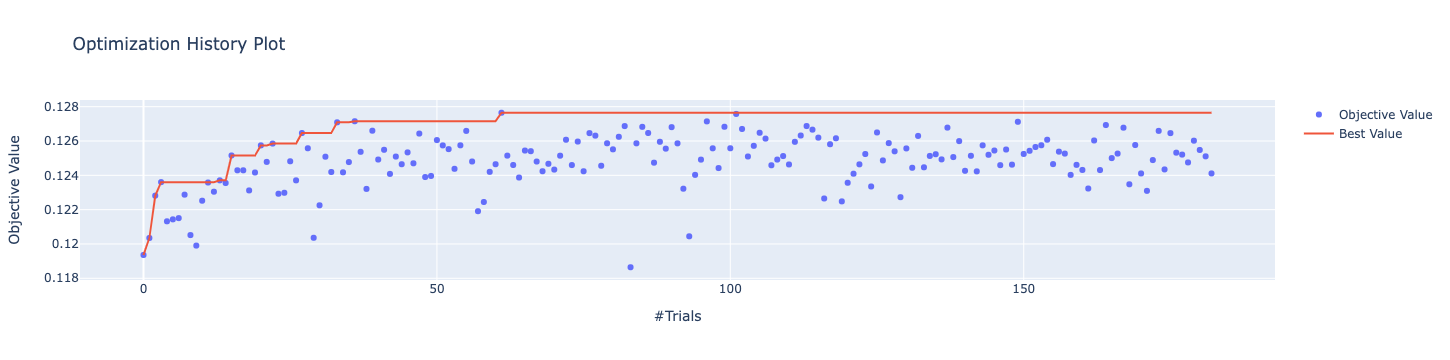

In [39]:
plot_optimization_history(study)

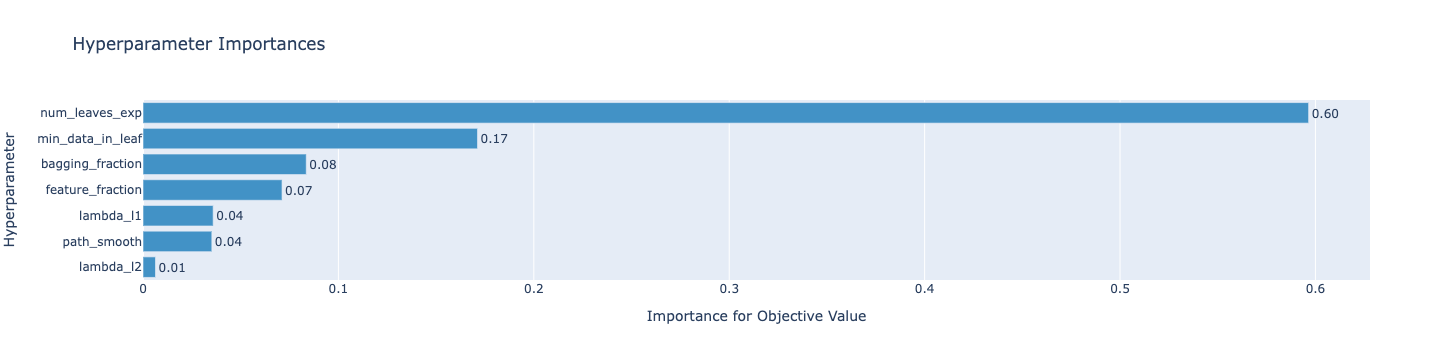

In [40]:
plot_param_importances(study)

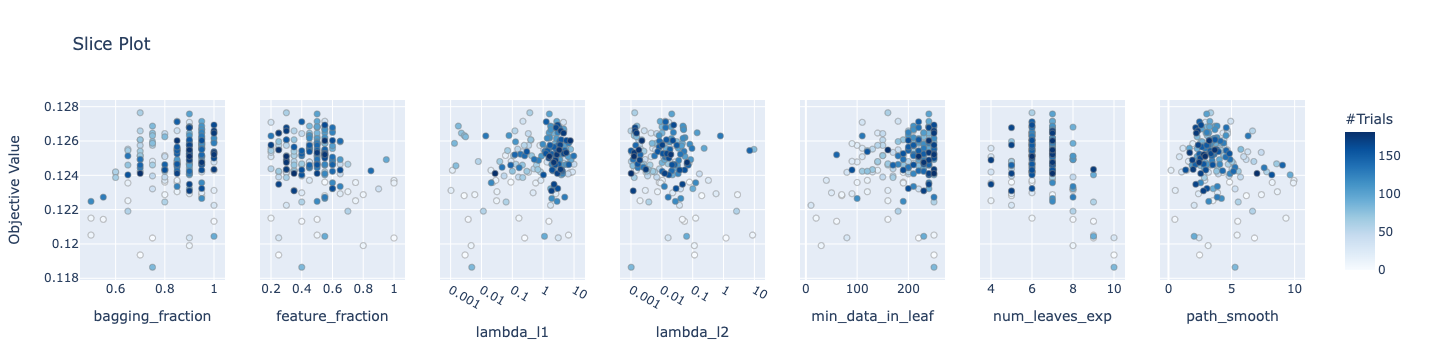

In [41]:
plot_slice(study)

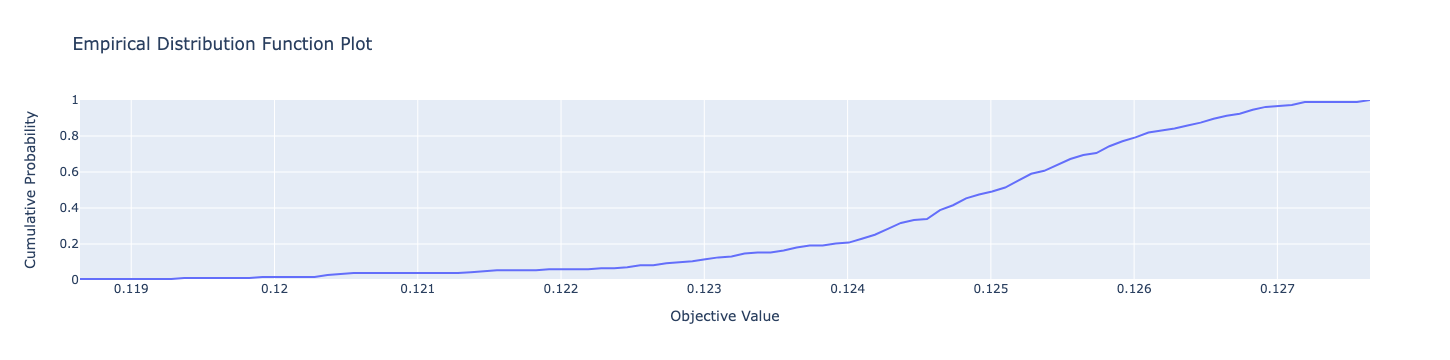

In [42]:
plot_edf(study)

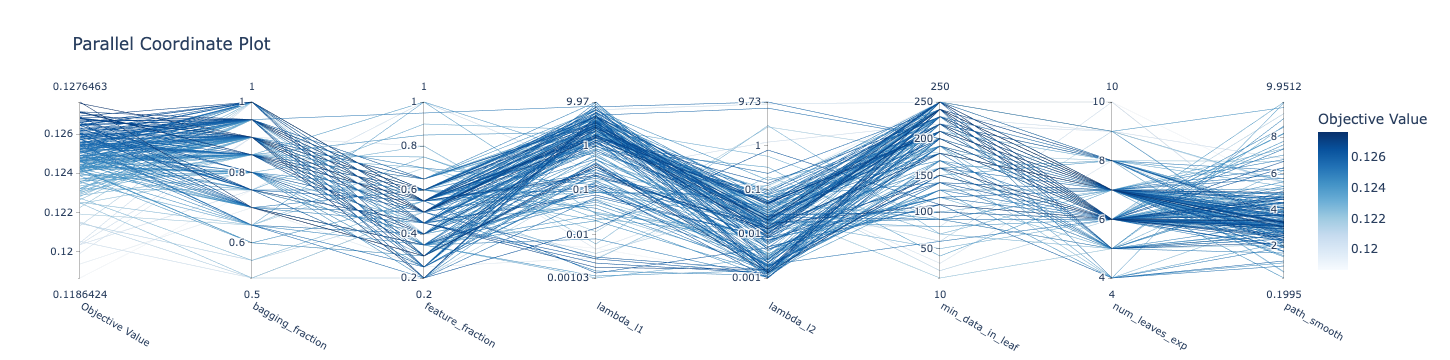

In [43]:
plot_parallel_coordinate(study)

In [46]:
best_params = dict(study.best_params)
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")
best_params = {**default_params, **best_params}
best_params

{'objective': 'mse',
 'metric': 'rmse',
 'learning_rate': 0.05,
 'force_col_wise': True,
 'bagging_freq': 1,
 'seed': 19,
 'verbosity': -1,
 'first_metric_only': False,
 'bin_construct_sample_cnt': 100000000,
 'feature_pre_filter': False,
 'bagging_fraction': 0.7,
 'feature_fraction': 0.30000000000000004,
 'lambda_l1': 0.3678902559115776,
 'lambda_l2': 0.0013190869965539825,
 'min_data_in_leaf': 160,
 'path_smooth': 3.3475021333279313,
 'num_leaves': 64}

***